In [4]:
!pip install num2fawords


In [5]:
!pip install parsivar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 21.9 MB/s eta 0:00:00


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
import transformers
import JackageNormalizer

from parsivar import Tokenizer
from JackageNormalizer import normalize_persian_text

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

import tqdm as notebook_tqdm

testing the pip line...

the model I chose only has a PyTorch checkpoint.

In [ ]:
# Use a pipeline as a high-level helper
pipe = pipeline("text-classification", model="HooshvareLab/bert-fa-base-uncased-sentiment-snappfood", framework="tf")
# Example usage of the pipeline
result = pipe("این غذا خیلی خوشمزه بود!")
print(result)

### 1. Load and Inspect Your Dataset

In [13]:
df = pd.read_csv("/content/cleaned_snappfood copy.csv")
df.head()

,comment,label,comment_length,comment_cleaned
0,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,0,47,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح
1,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,1,132,قرار بود ساعته برسه ولی نیم ساعت زودتر از موق...
2,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,0,89,قیمت این مدل اصلا با کیفیتش سازگاری نداره فقط ...
3,عالی بود همه چه درست و به اندازه و کیفیت خوب، ...,1,99,عالی بود همه چه درست و به اندازه و کیفیت خوب ا...
4,شیرینی وانیلی فقط یک مدل بود.,1,29,شیرینی وانیلی فقط یک مدل بود


In [14]:
df.info()
df.isnull().count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65973 entries, 0 to 65972
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   comment          65973 non-null  object
 1   label            65973 non-null  int64 
 2   comment_length   65973 non-null  int64 
 3   comment_cleaned  65973 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.0+ MB


,0
comment,65973
label,65973
comment_length,65973
comment_cleaned,65973


In [15]:
df.shape
df.columns

Index(['comment', 'label', 'comment_length', 'comment_cleaned'], dtype='object')

In [16]:
df = df[['comment', 'label']]
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
tokenizer = Tokenizer()

def clean_text(text):
    text = normalize_persian_text(text)
    tokens = tokenizer.tokenize_words(text)
    return ' '.join(tokens)


In [20]:
df['comment'] = df['comment'].apply(clean_text)

df['comment'].sample(20)

,comment
13038,بوفالو برگر خیلی تند کل کیفیت عالی خواهشا انقد...
24643,محتوای سالاد تازه نبود ارسال موقع
52007,کیفیت هات داگ خوب نبود اب انار خیلی تازه نبود تلخ
54926,یکم طعم مزه
44869,قیمت بالا کیفیت پایین غذا خصوصا برنج نامناسب ب...
55176,عالی بودش عالی مخصوصا رفتار پرسنل
1893,رستوران آدرس معمول رو آدرس سفارش اشتباه باعث ت...
29714,سلام مشتری ثابتون هستم همیشه تلفنی خرید میکردم...
15586,امتیاز اسنپ اکسپرس صفر دو ساعت طول کشید تحویل بدن
43435,نسبت قیمت ارزش نداره خوشمزه چیپس پنیر نداشت


#### Split into train / val / test

In [21]:
texts = df['comment'].tolist()
labels = df['label'].values

In [22]:
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42
)

70% → train

15% → validation

15% → test

In [23]:
print(f"Train shape: {len(train_texts)}, Validation shape: {len(val_texts)}, Test shape: {len(test_texts)}\n")

print("Data loaded and processed successfully.")
print(f"Sample of cleaned text:\n ({train_texts[0]}) \n label: {train_labels[0]}")

Train shape: 46181, Validation shape: 9896, Test shape: 9896

Data loaded and processed successfully.
Sample of cleaned text:
 (سیبزمینی روغن مونده درست بو میداد قابل خوردن شکل شمایلش خوب نبود) 
 label: 0


### 2. Prepare Text and Tokenize

In [24]:
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-fa-base-uncased-sentiment-snappfood")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/621 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [25]:
def encode_texts(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=128)

In [26]:
train_encoded = encode_texts(train_texts)
val_encoded = encode_texts(val_texts)
test_encoded = encode_texts(test_texts)

convert Encoding to TF DataSet

In [27]:
def make_tf_dataset(encoding, labels, shuffle=False, BATCH_SIZE=16):
    dataset = tf.data.Dataset.from_tensor_slices((dict(encoding), labels))
    if shuffle:
        dataset = dataset.shuffle(1000)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [28]:
train_dataset = make_tf_dataset(train_encoded, train_labels, shuffle=True)
val_dataset = make_tf_dataset(val_encoded, val_labels)
test_dataset = make_tf_dataset(test_encoded, test_labels)

### 3. Laod the Model_Compile the Model_Train the Model

In [29]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    "HooshvareLab/bert-fa-base-uncased-sentiment-snappfood",
    num_labels=2,
    use_safetensors=True)

tf_model.h5:   0%|          | 0.00/652M [00:00<?, ?B/s]

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at HooshvareLab/bert-fa-base-uncased-sentiment-snappfood.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

In [31]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=3
)

Epoch 1/3
2887/2887 [==============================] - 874s 282ms/step - loss: 0.3201 - sparse_categorical_accuracy: 0.8674 - val_loss: 0.2871 - val_sparse_categorical_accuracy: 0.8874
Epoch 2/3
2887/2887 [==============================] - 803s 278ms/step - loss: 0.2543 - sparse_categorical_accuracy: 0.8973 - val_loss: 0.2988 - val_sparse_categorical_accuracy: 0.8803
Epoch 3/3
2887/2887 [==============================] - 802s 278ms/step - loss: 0.1908 - sparse_categorical_accuracy: 0.9267 - val_loss: 0.3572 - val_sparse_categorical_accuracy: 0.8605


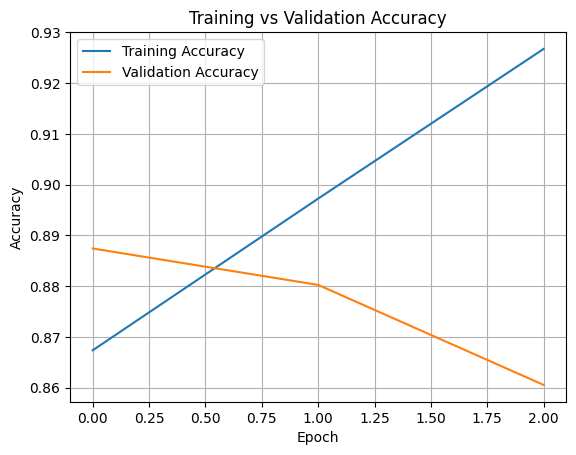

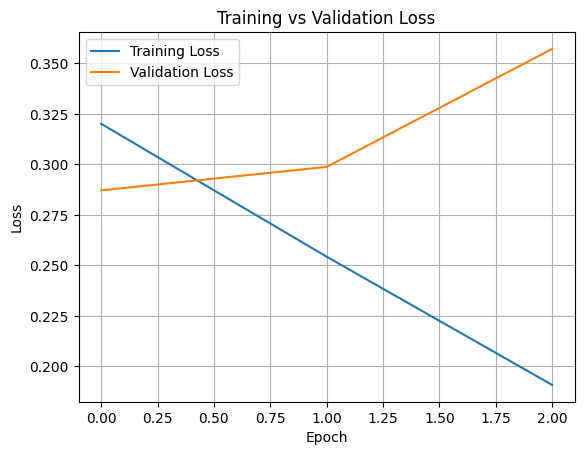

In [32]:
# Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### 4. Evaluate on TEST set

In [33]:
print("✅ Final Evaluation on Test Set")
model.evaluate(test_dataset)

✅ Final Evaluation on Test Set
619/619 [==============================] - 57s 87ms/step - loss: 0.3776 - sparse_categorical_accuracy: 0.8516


[0.3776339590549469, 0.8515561819076538]

### 5. Save the Fine-Tuned Model